In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.optimize import leastsq
from scipy.optimize import least_squares
import time
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D
from matplotlib.colors import LogNorm
from scipy.signal import convolve as scipy_convolve
from matplotlib import gridspec

In [2]:
def int_spec(mini_cube,mini_err):
    shape = mini_cube.shape[1]*mini_cube.shape[2]
    int_spectrum = sum(mini_cube[:,i,j] for i in range(mini_cube.shape[1]) for j in range(mini_cube.shape[2]))
    int_error = np.sqrt(sum((mini_err[:,i,j])**2 for i in range(mini_cube.shape[1]) for j in range(mini_cube.shape[2])))
    return int_spectrum,int_error

def redshift(vel):
    return vel/300000.0

def line_width(vel_sigma,rest_line,inst_res_fwhm=2.5):
    sigma = vel_sigma/(300000.0-vel_sigma)*rest_line
    return np.sqrt(sigma**2+(inst_res_fwhm/2.354)**2)

def gauss(wave,amplitude,vel,vel_sigma, rest_wave):
    line = (amplitude)*np.exp(-(wave-(rest_wave*(1+redshift(vel))))**2/(2*(line_width(vel_sigma, rest_wave))**2))
    return line 

def Hb_O3_gauss(wave,amp_Hb,amp_OIII5007,vel,vel_sigma):
    Hb = gauss(wave,amp_Hb,vel,vel_sigma,4861.33)
    OIII_4959 = (0.33)*gauss(wave,amp_OIII5007,vel,vel_sigma,4958.9)
    OIII_5007 = gauss(wave,amp_OIII5007,vel,vel_sigma,5006.8)
    return Hb + OIII_4959 + OIII_5007

def Hb_Fe_doublet_gauss(wave,amp_Hb,amp_Fe5018,vel,vel_sigma):
    Hb = gauss(wave,amp_Hb,vel,vel_sigma,4861.33)
    Fe_4923 = 0.81*gauss(wave,amp_Fe5018,vel,vel_sigma,4923)
    Fe_5018 = gauss(wave,amp_Fe5018,vel,vel_sigma,5018)
    return Hb+Fe_4923+Fe_5018

def full_gauss2(p,wave,data,error):
    (amp_Hb_1,amp_OIII50071,amp_Hb_2,amp_OIII50072,vel_core,vel_core_sigma,amp_Hb_br,amp_OIII5007_br,vel_wing,vel_wing_sigma,amp_Hb1,amp_Fe5018_1,amp_Hb2,amp_Fe5018_2,m,c)=p
    narrow_OIII1 = Hb_O3_gauss(wave,amp_Hb_1,amp_OIII50071,vel_core,vel_core_sigma)
    narrow_OIII2 = Hb_O3_gauss(wave,amp_Hb_2,amp_OIII50072,vel_core,vel_core_sigma)
    broad_OIII = Hb_O3_gauss(wave,amp_Hb_br,amp_OIII5007_br,vel_wing,vel_wing_sigma)
    Hb_broad1 = Hb_Fe_doublet_gauss(wave,amp_Hb1,amp_Fe5018_1,vel_core,vel_core_sigma) 
    Hb_broad2 = Hb_Fe_doublet_gauss(wave,amp_Hb2,amp_Fe5018_2,vel_core,vel_core_sigma) 
    cont = (wave/1000.0)*m+c
    return (narrow_OIII1+narrow_OIII2+broad_OIII+Hb_broad1+Hb_broad2+cont-data)/error

def full_gauss3(p,wave,data,error):
    (amp_Hb_1,amp_OIII50071,amp_Hb_2,amp_OIII50072,vel_core,vel_core_sigma,vel_wing,vel_wing_sigma,m,c)=p
    narrow_OIII1 = Hb_O3_gauss(wave,amp_Hb_1,amp_OIII50071,vel_core,vel_core_sigma)
    broad_OIII = 0#Hb_O3_gauss(wave,amp_Hb_2,amp_OIII50072,vel_wing,vel_wing_sigma) 
    cont = (wave/1000.0)*m+c
    return (narrow_OIII1+broad_OIII+cont-data)/error

In [3]:
hdu = fits.open('3C264-1s-hanii-STARSUB.fits')
qso_data = hdu[1].data
qso_error = hdu[2].data
qso_header = hdu[1].header
wavestart = qso_header['CRVAL3']  # central wavelength. CDELT3 is microns per pixel. 
wavint = qso_header['CD3_3']
#wave = wavestart+np.arange(qso_data.shape[0])*wavint. This is the same as the one below. 
#[central_x,central_y]= [57,57]#
qso_data[np.isnan(qso_data)] = 0.0000001
qso_error[np.isnan(qso_error)] = 0.000001
(central_y,central_x) = ndimage.measurements.maximum_position(qso_data[1584,:,:])

In [4]:
z = 0.02172
k = 1+z
c = 300000
central_vel = c*z

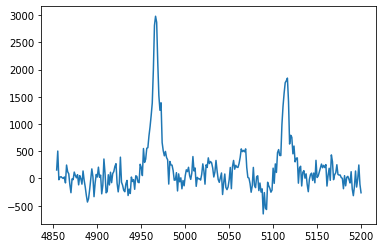

In [5]:
wave = np.arange(wavestart,(wavestart+(wavint*qso_data.shape[0])),wavint)#start,stop,step
select =(wave>4750*k)&(wave<5090*k)
x0 = 55
y0 = 58
x = wave[select]
data = qso_data[:,y0-1:y0+2,x0-1:x0+2][select]
data_err = qso_error[:,y0-1:y0+2,x0-1:x0+2][select]
(y,y_err) = int_spec(data,data_err) 
plt.plot(x,y)
plt.show()

In [6]:
popt,pcov = leastsq(full_gauss3,x0=[300,150,330,175,6516,100,6496,200,-0.001,0.1],args=(x,y,y_err),maxfev = 10000000)                                                    
print(popt)
[amp_Hb_1,amp_OIII50071,amp_Hb_2,amp_OIII50072,vel_core,vel_core_sigma,vel_wing,vel_wing_sigma,m,c] = popt

[2549.63100059 1621.39398016  330.          175.         6496.07967642
  280.94475324 6496.          200.           63.05648113 -306.51031107]


Text(0, 0.5, 'Residuals')

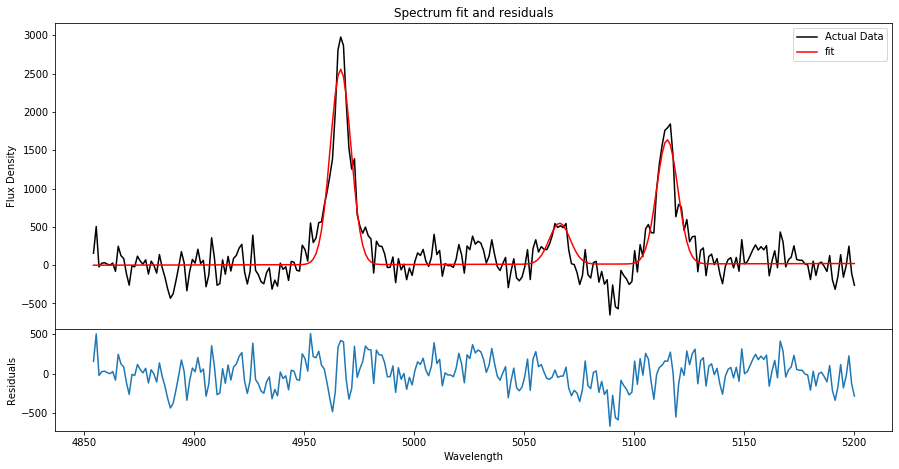

In [7]:
fit = full_gauss3(popt,x,y,y_err)*(y_err)+y
residual = y - fit

plt.figure(figsize=(15,7.5))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # # set height ratios for sublots

ax1=plt.subplot(gs[0])  # first subplot
ax1.plot(x,y,'-k',label='Actual Data')
ax1.plot(x,fit,'-r',label='fit')

#plt.plot(x,Hb_O3_gauss(x,amp_Hb_1,amp_OIII50071,vel_core,vel_core_sigma),'--g',label='core')
#plt.plot(x,Hb_O3_gauss(x,amp_Hb_2,amp_OIII50072,vel_wing,vel_wing_sigma),'--b',label='wing')

plt.title('Spectrum fit and residuals')
plt.ylabel('Flux Density')
plt.legend()

ax2=plt.subplot(gs[1])  # second subplot
plt.plot(x,residual)
plt.subplots_adjust(hspace=0)
plt.xlabel('Wavelength')
plt.ylabel('Residuals')

In [8]:
mini_cube = qso_data[:,central_y - 22:central_y + 23,central_x - 22:central_x + 23]
mini_cube_error = qso_error[:,central_y - 22:central_y + 23,central_x - 22:central_x + 23]
qso_header['CRPIX1'] = qso_header['CRPIX1'] - (central_x - 22)
qso_header['CRPIX2'] = qso_header['CRPIX2'] - (central_y - 22)
new_hdu = fits.HDUList([fits.PrimaryHDU(mini_cube),fits.ImageHDU(mini_cube_error)])
new_hdu[0].header = qso_header
wave = np.arange(wavestart,(wavestart+(wavint*mini_cube.shape[0])),wavint)

In [9]:
#mini_data = qso_data
#mini_error = np.sqrt(qso_error)
mini_data = mini_cube
mini_error = np.sqrt(mini_cube_error)

In [10]:
select = (wave > 4750*k) & (wave < 5090*k)
select2 = (wave > 6552*k) & (wave < 6572*k) 
select3 = (wave > 6750*k) & (wave < 6780*k)
par = np.zeros((10,mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
err = np.zeros((10,mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
fitted = np.zeros((np.shape(wave[select])[0],mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
residuals = np.zeros((np.shape(wave[select])[0],mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)

In [11]:
start = time.time()

for i in range(mini_data.shape[1]):
    for j in range(mini_data.shape[2]):
        y = mini_data[:,i,j][select]
        y_err = mini_error[:,i,j][select]
        x = wave[select]    
        
        popt,pcov = leastsq(full_gauss3,x0=[300,150,330,175,6516,100,6496,200,-0.001,0.1],args=(x,y,y_err),maxfev = 10000000)                                                    
        par[:,i,j] = popt
        
#         model = full_gauss(popt1,x,y,y_err)*(y_err)+y
#         fitted[:,i,j] = model
        
#         #plt.plot(x,y)
#         #plt.plot(x,model)
#         #plt.show()
        
        residuals[:,i,j] = mini_data[:,i,j][select] - fitted[:,i,j]

        Monte_Carlo_loops = 100  # larger the sample size, more accurate it is. 
        parameters_MC = np.zeros((len(popt),Monte_Carlo_loops))  # for each loop, we have the fit parameters. 
        
        for l in range(Monte_Carlo_loops):
            iteration_data = np.random.normal(y,y_err)
            popt_MC,pcov_MC = leastsq(full_gauss3,x0=[300,150,330,175,6516,100,6496,200,-0.001,0.1],args=(x,iteration_data,y_err),maxfev = 10000000)                                                                  
            parameters_MC[:,l]=popt_MC
            
        parameters_err = np.nanstd(parameters_MC,1)
        err[:,i,j]=parameters_err
        

print("Time elapsed: ", str(time.time() - start))

Time elapsed:  2817.939826965332


In [12]:
hdus=[]
hdus.append(fits.PrimaryHDU())
hdus.append(fits.ImageHDU(par[0,:,:],name='amp_Hb_1'))
hdus.append(fits.ImageHDU(par[1,:,:],name='amp_OIII_1'))
hdus.append(fits.ImageHDU(par[2,:,:],name='amp_Hb_2'))
hdus.append(fits.ImageHDU(par[3,:,:],name='amp_OIII50072'))
hdus.append(fits.ImageHDU(par[4,:,:],name='vel_core'))
hdus.append(fits.ImageHDU(par[5,:,:],name='vel_core_sigma'))
hdus.append(fits.ImageHDU(par[6,:,:],name='vel_wing'))
hdus.append(fits.ImageHDU(par[7,:,:],name='vel_wing_sigma'))
hdus.append(fits.ImageHDU(par[8,:,:],name='m'))
hdus.append(fits.ImageHDU(par[9,:,:],name='c'))
hdu = fits.HDUList(hdus)
hdu.writeto('subcube_par_3C264_45x45_HbO3.fits',overwrite=True)

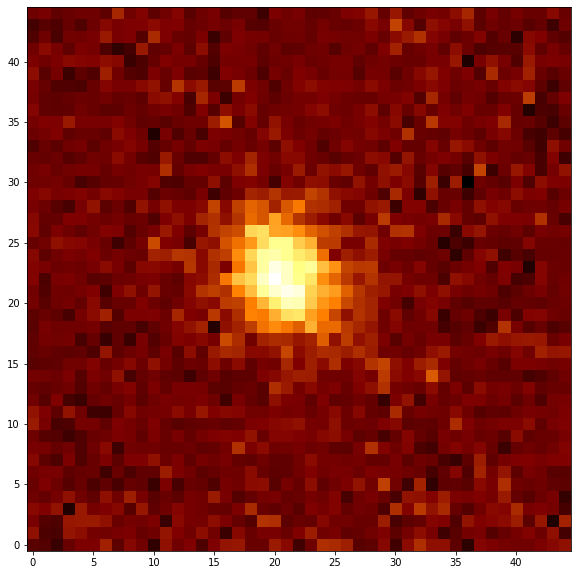

In [13]:
with fits.open('subcube_par_3C264_45x45_HbO3.fits') as hdu:

#hdu = fits.open('subcube_par_3C264_LSQ_45x45_updated.fits')

    Hb_1 = hdu[1].data
    OIII_1 = hdu[2].data
    Hb_2 = hdu[3].data
    OIII_2 = hdu[4].data
    vel_core = hdu[5].data
    vel_core_sigma = hdu[6].data
    vel_wing = hdu[7].data
    vel_wing_sigma = hdu[8].data
    m = hdu[9].data
    c = hdu[10].data
    hdu.close()

plt.figure(figsize=(10,10))
plt.imshow(OIII_1,cmap='afmhot',origin='lower')

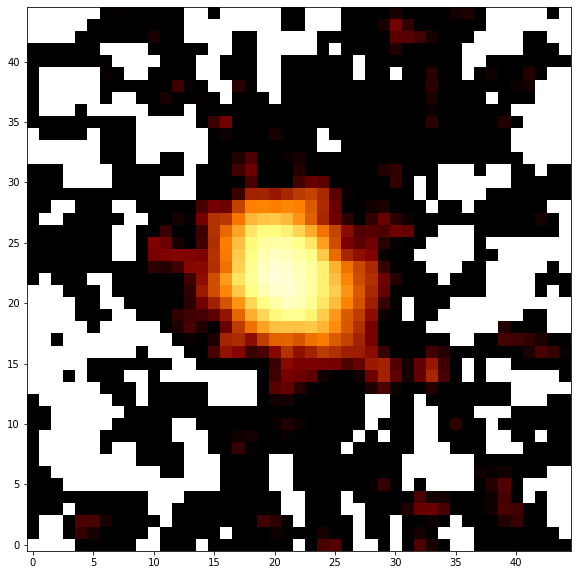

In [14]:
fig=plt.figure(figsize=(10,10))
kernel = Gaussian2DKernel(0.75)
smoothed_data_gauss = convolve(OIII_1, kernel)  #convolving takes the bad values and smooths them to more reasonable values. 
plt.imshow(smoothed_data_gauss,cmap='afmhot',interpolation='none',origin='lower',vmin=10,vmax=250,norm=LogNorm())

In [15]:
(y0,x0) = ndimage.measurements.maximum_position(OIII_1)
print(y0,x0)

# QFitsView says: Image X = 55.672 and Image Y = 57.678

22 20


In [17]:
hdus=[]
hdus.append(fits.PrimaryHDU())
hdus.append(fits.ImageHDU(err[0,:,:],name='amp_Hb_1_err'))
hdus.append(fits.ImageHDU(err[1,:,:],name='amp_OIII_1_err'))
hdus.append(fits.ImageHDU(err[2,:,:],name='amp_Hb_2_err'))
hdus.append(fits.ImageHDU(err[3,:,:],name='amp_OIII50072_err'))
hdus.append(fits.ImageHDU(err[4,:,:],name='vel_core_err'))
hdus.append(fits.ImageHDU(err[5,:,:],name='vel_core_sigma_err'))
hdus.append(fits.ImageHDU(err[6,:,:],name='vel_wing_err'))
hdus.append(fits.ImageHDU(err[7,:,:],name='vel_wing_sigma_err'))
hdus.append(fits.ImageHDU(err[8,:,:],name='m_err'))
hdus.append(fits.ImageHDU(err[9,:,:],name='c_err'))
hdu = fits.HDUList(hdus)
hdu.writeto('subcube_par_3C264_err_45x45_HbO3_100loops.fits',overwrite=True)

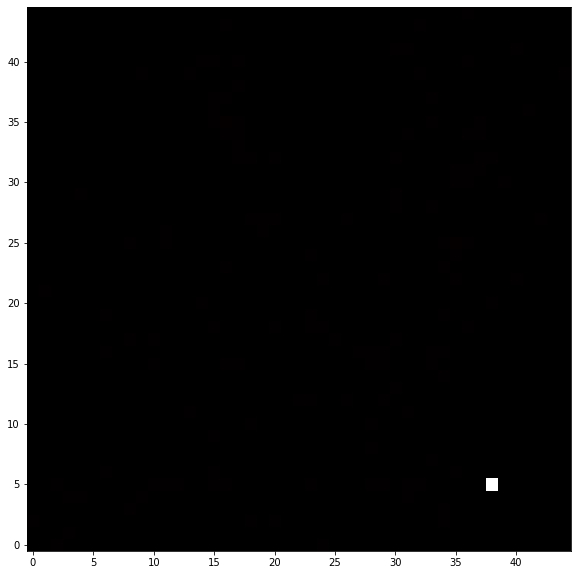

In [18]:
with fits.open('subcube_par_3C264_err_45x45_HbO3_100loops.fits') as hdu:

#hdu = fits.open('subcube_par_3C264_LSQ_45x45_updated.fits')

    Hb_1_err = hdu[1].data
    OIII_1_err = hdu[2].data
    Hb_2_err = hdu[3].data
    OIII_2_err = hdu[4].data
    vel_core_err = hdu[5].data
    vel_core_sigma_err = hdu[6].data
    vel_wing_err = hdu[7].data
    vel_wing_sigma_err = hdu[8].data
    m_err = hdu[9].data
    c_err = hdu[10].data
    hdu.close()

plt.figure(figsize=(10,10))
plt.imshow(OIII_1_err,cmap='afmhot',origin='lower')

In [12]:
#hdu.open=('subcube_par_HE0232-0900_LSQ2.fits')
#Hb_blr = hdu[5].data
#OIII_nr = hdu[2].data
#OIII_br = hdu[3].data
#hdu.close()
#Hb_blr_centroid = ndimage.measurements.center_of_mass(Hb_blr)
#OIII_nr_centroid = ndimage.measurements.center_of_mass(OIII_nr)
#OIII_br_centroid = ndimage.measurements.center_of_mass(OIII_br)
#print('Centroid of Hb_blr is: ',Hb_blr_centroid)
#print('Centroid of OIII_nr is: ',OIII_nr_centroid)
#print('Centroid of OIII_br is: ',OIII_br_centroid)

In [13]:
#outflow_size_pix = np.sqrt((OIII_br_centroid[0] -  Hb_blr_centroid[0])**2 + (OIII_br_centroid[1] -  Hb_blr_centroid[1])**2)
#outflow_size_arc = 0.4*outflow_size_pix   
#print(outflow_size_arc)

In [14]:
#need distance to galaxy to find distance in parsec
#distance = 175.5
#outflow_size_parsec = (distance*outflow_size_arc)*4.848
#print(outflow_size_parsec) 
#Check MOFFAT

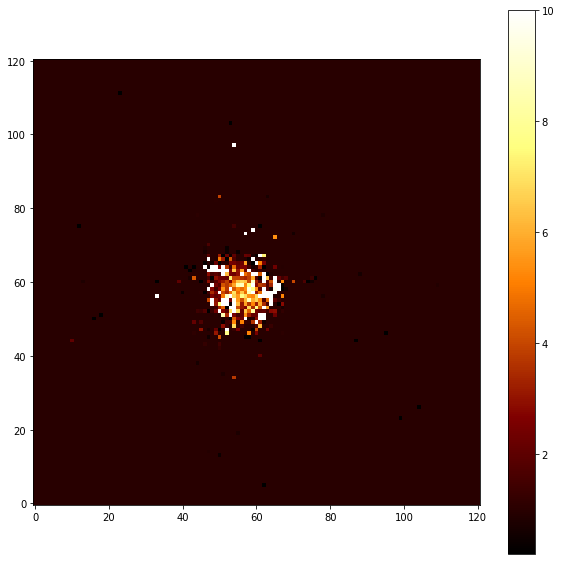

In [16]:
plt.figure(figsize=(10,10))
ratio_core = par[3,:,:]/par[1,:,:]
ratio_wing = par[4,:,:]/par[2,:,:]
plt.imshow(ratio_core,vmin=0.2,vmax=10,origin='lower',cmap='afmhot')  # for SII we can get the electron density from the core. core is extended so high electron density
plt.colorbar()
## NII and Ha ratio gives us the extent of ionization. Ha is not ionized, while NII is. 

In [48]:
# plt.figure(figsize=(10,10))
# smoothed_data_gauss = convolve(ratio_core, kernel)  #convolving takes the bad values and smooths them to more reasonable values. 
# plt.imshow(smoothed_data_gauss,cmap='afmhot',interpolation='none',origin='lower',vmin=0.2,vmax=10)

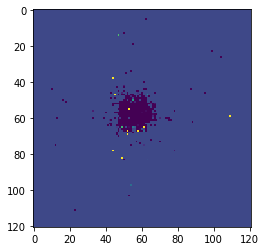

In [17]:
plt.imshow(ratio_wing,vmin=0.45,vmax=3)  # may be a pointlike outflow. If it was extended, we would see high electron density

In [50]:
# def BIC(data,model,n_free_par):
#     N = len(data)
#     BIC=stats.chisquare(data,model)[0] +n_free_par*(np.log(N) - np.log(2*np.pi))
#     return BIC

In [ ]:
# ccd pixels can't resolve faraway objects, so they're convolved. point like emission seems to be spread out. 
# accounting for geometry of imaging system, if we deconvolve to find out actual signal, we can see what the actual structure of 
# the signal. This is the PSF. 